In [132]:
#Import relevant modules, import data and all that
import numpy as np
from scipy import interpolate
import corner
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc
#plt.rcParams['font.family'] = 'DejaVu Sans'
#rc('text', usetex=True)
plt.rcParams.update({'font.size': 16.5})

import ptemcee
#from pycbc.pool import choose_pool
from multiprocessing import Pool
import h5py
import inspect
import pandas as pd
import json
import qnm
import random
import dynesty
from dynesty import plotting as dyplot

#Remember to change the following global variables
#rootpath: root path to nr data
#npoints: number of points you re using for your sampling
#nmax: tone index --> nmax = 0 if fitting the fundamental tone
#tshift: time shift after the strain peak
#vary_fund: whether you vary the fundamental frequency. Works in the model_dv function.

rootpath= "/work/francisco.jimenez/sio"#"/work/rayne.liu"
nmax=1
tshift=12
t_align=0
vary_fund = True

#sampler parameters
npoints = 1500
nwalkers = 400
npoints = 1000
ntemps=20
dim = nmax+1
ndim = 4*dim
burnin = 1200  #How many points do you burn before doing the corner plot. You need to watch the convergence of the chain plot a bit.
            #This is trivial but often forgotten: this cannot be more than npoints! I usually use half the points.
numbins = 32 #corner plot parameter - how many bins you want
datacolor = '#105670' #'#4fa3a7'
pkcolor = '#f2c977' #'#ffb45f'
mediancolor = '#f7695c' #'#9b2814'
mismatch2=0.0002
error=np.sqrt(mismatch2)


#Import data and necessary functions
#TimeOfMaximum
def FindTmaximum(y):
    #Determines the maximum absolute value of the complex waveform
    absval = np.sqrt(y[:,1]*y[:,1]+y[:,2]*y[:,2])
    vmax=np.max(absval)
    index = np.argmax(absval == vmax)
    timemax=y[index,0]
    return timemax


def EasyMatchT(t,h1,h2,tmin,tmax):
    #Computes the match for complex waveforms
    pos = np.argmax(t >= (tmin));
    
    h1red=h1[pos:-1];
    h2red=h2[pos:-1];
    
    norm1=np.sum(np.abs(h1red)**2)
    norm2=np.sum(np.abs(h2red)**2)

    myTable=h1red*np.conjugate(h2red)
    res=((np.sum(myTable)/np.sqrt(norm1*norm2))).real
    
    return res

In [133]:
#This loads the 22 mode data
gw = {}
gw["SXS:BBH:0305"] = h5py.File(rootpath+"/git/rdstackingproject/SXS/BBH_SKS_d14.3_q1.22_sA_0_0_0.330_sB_0_0_-0.440/Lev6/rhOverM_Asymptotic_GeometricUnits_CoM.h5", 'r')
gw_sxs_bbh_0305 = gw["SXS:BBH:0305"]["Extrapolated_N3.dir"]["Y_l2_m2.dat"]


gw5 = {}
gw5["SXS:BBH:0305"] = h5py.File(rootpath+"/git/rdstackingproject/SXS/BBH_SKS_d14.3_q1.22_sA_0_0_0.330_sB_0_0_-0.440/Lev5/rhOverM_Asymptotic_GeometricUnits_CoM.h5", 'r')
gw5_sxs_bbh_0305 = gw5["SXS:BBH:0305"]["Extrapolated_N3.dir"]["Y_l2_m2.dat"]
# Remember to download metadata.json from the simulation with number: 0305. Download Lev6/metadata.json
# This postprocesses the metadata file to find the final mass and final spin
metadata = {}
with open(rootpath+"/git/rdstackingproject/SXS/BBH_SKS_d14.3_q1.22_sA_0_0_0.330_sB_0_0_-0.440/Lev5/metadata.json") as file:
    metadata["SXS:BBH:0305"] = json.load(file)

af = metadata["SXS:BBH:0305"]['remnant_dimensionless_spin'][-1]
mf = metadata["SXS:BBH:0305"]['remnant_mass']

#times --> x axis of your data
times = gw_sxs_bbh_0305[:,0]
tmax=FindTmaximum(gw_sxs_bbh_0305)
times = times - tmax

#times 6--> x axis of your data
times5 = gw5_sxs_bbh_0305[:,0]
tmax5=FindTmaximum(gw5_sxs_bbh_0305)
times5 = times5 - tmax5

In [134]:
#Select the data from 0 onwards
position = np.argmax(times >= (0))
position5 = np.argmax(times5 >= (0))
gw_sxs_bbh_0305rd=gw_sxs_bbh_0305[position+1:-1]
gw_sxs_bbh_0305rd5=gw5_sxs_bbh_0305[position5+1:-1]
timesrd=gw_sxs_bbh_0305[position:-1][:,0][:-1]-tmax
timesrd5=gw5_sxs_bbh_0305[position5:-1][:,0][:-1]-tmax5

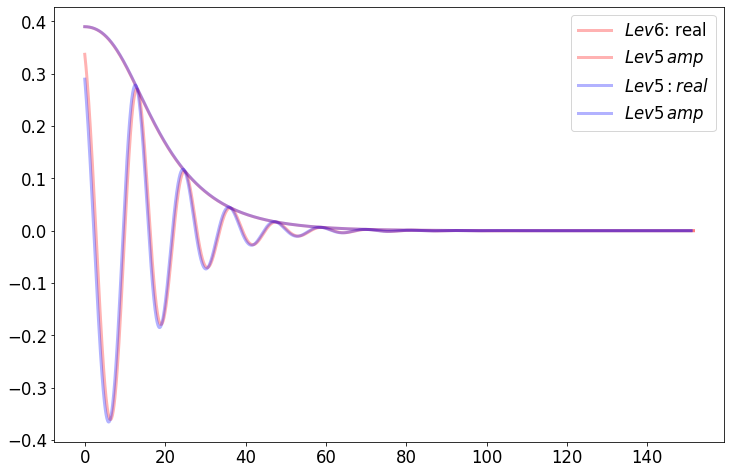

In [135]:
#Test plot real part (data was picked in the last cell). Aligning in time
plt.figure(figsize = (12, 8))
plt.plot(timesrd, gw_sxs_bbh_0305rd[:,1], "r", alpha=0.3, lw=3, label=r'$Lev6$: real')
plt.plot(timesrd, np.sqrt(gw_sxs_bbh_0305rd[:,1]**2+gw_sxs_bbh_0305rd[:,2]**2), "r", alpha=0.3, lw=3, label=r'$Lev5\,amp$')
plt.plot(timesrd5, gw_sxs_bbh_0305rd5[:,1], "b", alpha=0.3, lw=3, label=r'$Lev5: real$')
plt.plot(timesrd5, np.sqrt(gw_sxs_bbh_0305rd5[:,1]**2+gw_sxs_bbh_0305rd5[:,2]**2), "b", alpha=0.3, lw=3, label=r'$Lev5\,amp$')
plt.legend()

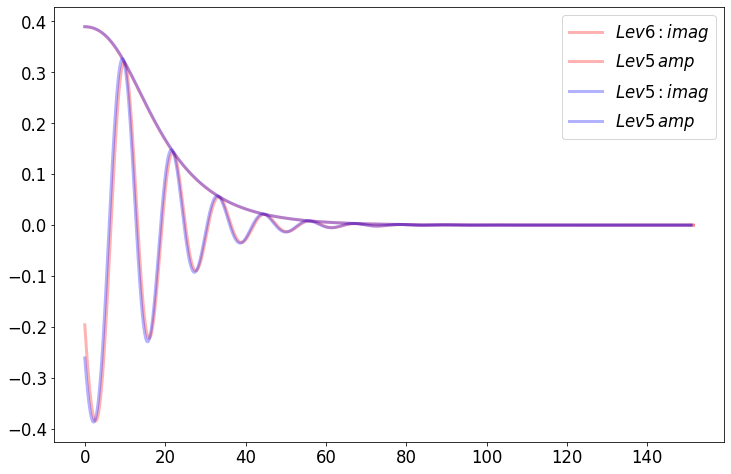

In [136]:
#Test plot im part (data was picked in the last cell). Aligning in time
plt.figure(figsize = (12, 8))
plt.plot(timesrd, gw_sxs_bbh_0305rd[:,2], "r", alpha=0.3, lw=3, label=r'$Lev6: imag$')
plt.plot(timesrd, np.sqrt(gw_sxs_bbh_0305rd[:,1]**2+gw_sxs_bbh_0305rd[:,2]**2), "r", alpha=0.3, lw=3, label=r'$Lev5\,amp$')
plt.plot(timesrd5, gw_sxs_bbh_0305rd5[:,2], "b", alpha=0.3, lw=3, label=r'$Lev5: imag$')
plt.plot(timesrd5, np.sqrt(gw_sxs_bbh_0305rd5[:,1]**2+gw_sxs_bbh_0305rd5[:,2]**2), "b", alpha=0.3, lw=3, label=r'$Lev5\,amp$')
plt.legend()

In [137]:
# Depending on nmax, you load nmax number of freqs. and damping times from the qnm package
omegas = [qnm.modes_cache(s=-2,l=2,m=2,n=i)(a=af)[0] for i in range (0,dim)]
w = (np.real(omegas))/mf
tau=-1/(np.imag(omegas))*mf

In [138]:
gwnew_re = interpolate.interp1d(timesrd, gw_sxs_bbh_0305rd[:,1], kind = 'cubic')
gwnew_im = interpolate.interp1d(timesrd, gw_sxs_bbh_0305rd[:,2], kind = 'cubic')

gwnew_re5 = interpolate.interp1d(timesrd5, gw_sxs_bbh_0305rd5[:,1], kind = 'cubic')
gwnew_im5 = interpolate.interp1d(timesrd5, gw_sxs_bbh_0305rd5[:,2], kind = 'cubic')

In [139]:
if timesrd5[-1]>= timesrd[-1]: 
    timesrd_final = timesrd
else:
    timesrd_final = timesrd5

gwdatanew_re = gwnew_re(timesrd_final)
gwdatanew_im = gwnew_im(timesrd_final)
gwdatanew_re5 = gwnew_re5(timesrd_final)
gwdatanew_im5 = gwnew_im5(timesrd_final)

gwdatanew = gwdatanew_re - 1j*gwdatanew_im
gwdatanew5 = gwdatanew_re5- 1j*gwdatanew_im5

In [140]:
mismatch=1-EasyMatchT(timesrd_final,gwdatanew,gwdatanew5,0,0+90)
error=np.sqrt(2*mismatch)
print(mismatch)

0.02010791222971675


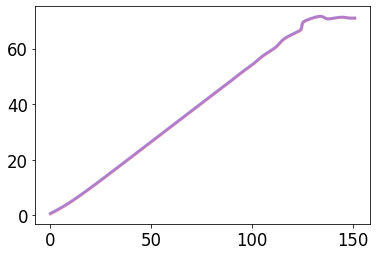

In [141]:
# Phase alignement
phas = np.angle(gwdatanew)
phas = np.unwrap(phas)
phas5 = np.angle(gwdatanew5)
phas5 = np.unwrap(phas5)
plt.plot(timesrd_final, phas, "r", alpha=0.3, lw=3, label=r'$phase$')
plt.plot(timesrd_final, phas5, "blue", alpha=0.3, lw=3, label=r'$phase$')

0.20722293240753042


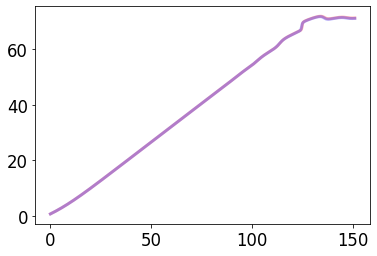

In [142]:
position = np.argmax(timesrd_final >= (t_align))
dphase = phas5[position]-phas[position]
print(dphase)

gwdatanew = (gwdatanew_re - 1j*gwdatanew_im)*np.exp(1j*dphase)
#gw_sxs_bbh_0305rd6=gw6_sxs_bbh_0305[position6:-1]
#timesrd=gw_sxs_bbh_0305[position:-1][:,0][:920]
phas = np.angle(gwdatanew)
phas = np.unwrap(phas)

phas5 = np.angle(gwdatanew5)
phas5 = np.unwrap(phas5)
plt.plot(timesrd_final, phas, "r", alpha=0.3, lw=3, label=r'$phase$')
plt.plot(timesrd_final, phas5, "blue", alpha=0.3, lw=3, label=r'$phase$')

In [143]:
mismatch=1-EasyMatchT(timesrd_final,gwdatanew,gwdatanew5,0,+90)
print(mismatch)
error = np.sqrt(2*gwdatanew*gwdatanew-2*gwdatanew*gwdatanew5)
#error**2=(h1-h2)**2

2.9903614015891478e-05


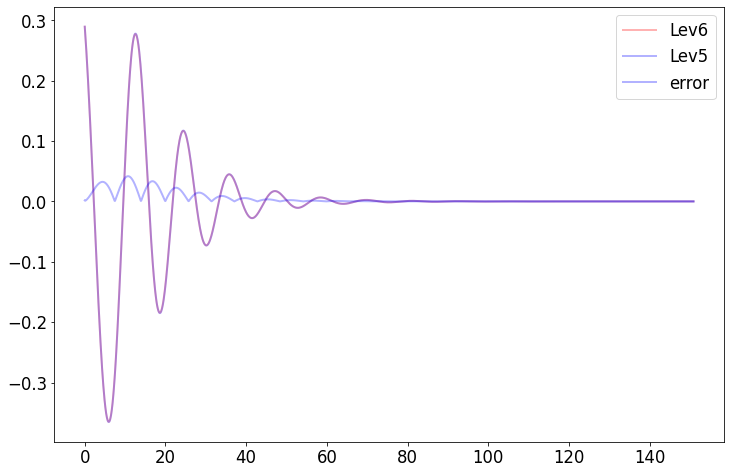

In [144]:
#Test the new interpolated data
plt.figure(figsize = (12, 8))
plt.plot(timesrd_final, gwdatanew.real, "r", alpha=0.3, lw=2, label='Lev6')
plt.plot(timesrd_final, gwdatanew5.real, "b", alpha=0.3, lw=2, label='Lev5')
plt.plot(timesrd_final, error.real, "b", alpha=0.3, lw=2, label='error')
plt.legend()

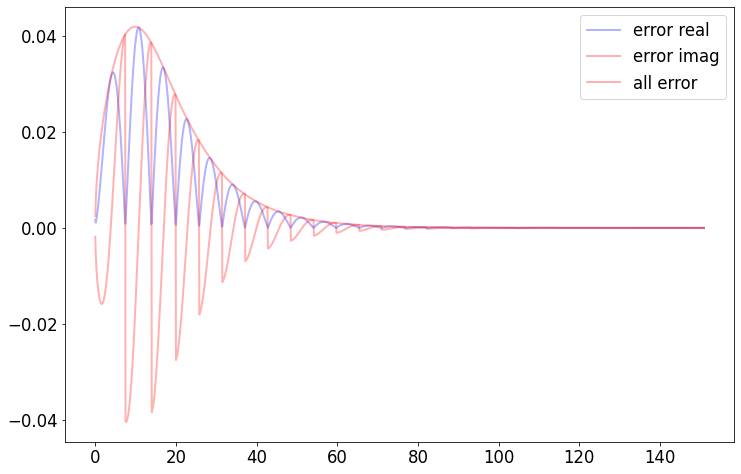

In [145]:
#Test the error data
plt.figure(figsize = (12, 8))
plt.plot(timesrd_final, error.real, "b", alpha=0.3, lw=2, label='error real')
plt.plot(timesrd_final, error.imag, "r", alpha=0.3, lw=2, label='error imag')
plt.plot(timesrd_final, np.sqrt(error.imag**2+error.real**2), "r", alpha=0.3, lw=2, label='all error')
plt.legend()

In [146]:
#Take the piece of waveform you want
position = np.argmax(timesrd_final >= tshift)
timesrd_final_tsh = timesrd_final[position:920]
gwdatanew_re_tsh = gwdatanew_re[position:920]
gwdatanew_im_tsh = gwdatanew_im[position:920]
error_tsh=error[position:920]
#timespan_new=timesrd_final[0:920]
#gwdatanew_re=gwdatanew_re[0:920]
#gwdatanew_im=gwdatanew_im[0:920]
#error=error[0:920]

In [154]:
#Fitting
#RD model for nmax tones. Amplitudes are in (xn*Exp[i yn]) version. Used here.
def model_dv(theta):
    #x0, y0= theta
    #Your nmax might not align with the dim of theta. Better check it here.
    assert int(len(theta)/4) == dim, 'Please recheck your n and parameters'
    
    wvars = theta[ : (dim)]
    tvars = theta[(dim) : 2*(dim)]
    xvars = theta[2*(dim) : 3*(dim)]
    yvars = theta[3*(dim) : ]
    
    #if vary_fund == False:
    #    avars[0]=0
    #    bvars[0]=0
        
    ansatz = 0
    for i in range (0,dim):
        #bvars[1]=0
        #avars[1]=0
        ansatz += (xvars[i]*np.exp(1j*yvars[i]))*np.exp(-timesrd_final_tsh/tvars[i]) * (np.cos(wvars[i]*timesrd_final_tsh)-1j*np.sin(wvars[i]*timesrd_final_tsh))
    # -1j to agree with SXS convention
    return ansatz

def prior_transform(cube):
    cube[0] =  0.5+ cube[0]*0.1
    cube[1] =  0.35 + cube[1]*0.35
    cube[2] =  8 + cube[2]*8  
    cube[3] =  0 + cube[3]*7
    cube[4] = 0 + cube[4]*3
    cube[5] = 0 + cube[5]*30
    cube[6] = 0 + cube[6]*2*np.pi
    cube[7] = 0 + cube[7]*2*np.pi
    return cube


# LogLikelihood function. It is just a Gaussian loglikelihood based on computing the residuals^2
def log_likelihood(theta):
    modelev = model_dv(theta)
    result = -np.sum(((gwdatanew_re_tsh - modelev.real)**2+(gwdatanew_im_tsh - modelev.imag)**2)/(2*(error_tsh.real**2+error_tsh.imag**2)))
    if np.isnan(result):
        return -np.inf
    return result


# Logposterior distribution for the residuals case.
# The evidence is just a normalization factor
def log_probability(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta)

In [155]:
f2=dynesty.NestedSampler(log_likelihood, prior_transform, ndim, nlive=npoints)
f2.run_nested()

3298it [00:11, 72.09it/s, bound: 0 | nc: 101 | ncall: 24826 | eff(%): 13.284 | loglstar:   -inf < -9776.093 <    inf | logz: -9785.854 +/-  0.137 | dlogz: 9339.160 >  1.009]    Traceback (most recent call last):
  File "/work/francisco.jimenez/sio/pyenv/versions/3.6.6/lib/python3.6/site-packages/dynesty/dynesty.py", line 939, in __call__
    return self.func(x, *self.args, **self.kwargs)
  File "<ipython-input-154-5e93979b5f76>", line 39, in log_likelihood
    modelev = model_dv(theta)
  File "<ipython-input-154-5e93979b5f76>", line 21, in model_dv
    ansatz += (xvars[i]*np.exp(1j*yvars[i]))*np.exp(-timesrd_final_tsh/tvars[i]) * (np.cos(wvars[i]*timesrd_final_tsh)-1j*np.sin(wvars[i]*timesrd_final_tsh))
KeyboardInterrupt
3298it [00:11, 276.80it/s, bound: 0 | nc: 101 | ncall: 24826 | eff(%): 13.284 | loglstar:   -inf < -9776.093 <    inf | logz: -9785.854 +/-  0.137 | dlogz: 9339.160 >  1.009]


Exception while calling loglikelihood function:
  params: [ 0.59904523  0.69585865 11.6323335   2.21761781  1.11784527 25.32226636
  2.03902056  5.55042952]
  args: []
  kwargs: {}
  exception:


KeyboardInterrupt: 

In [112]:
res = f2.results
res.samples_u.shape
res.summary()

Summary
nlive: 1000
niter: 502
ncall: 1653
eff(%): 90.865
logz: -0.055 +/-    nan


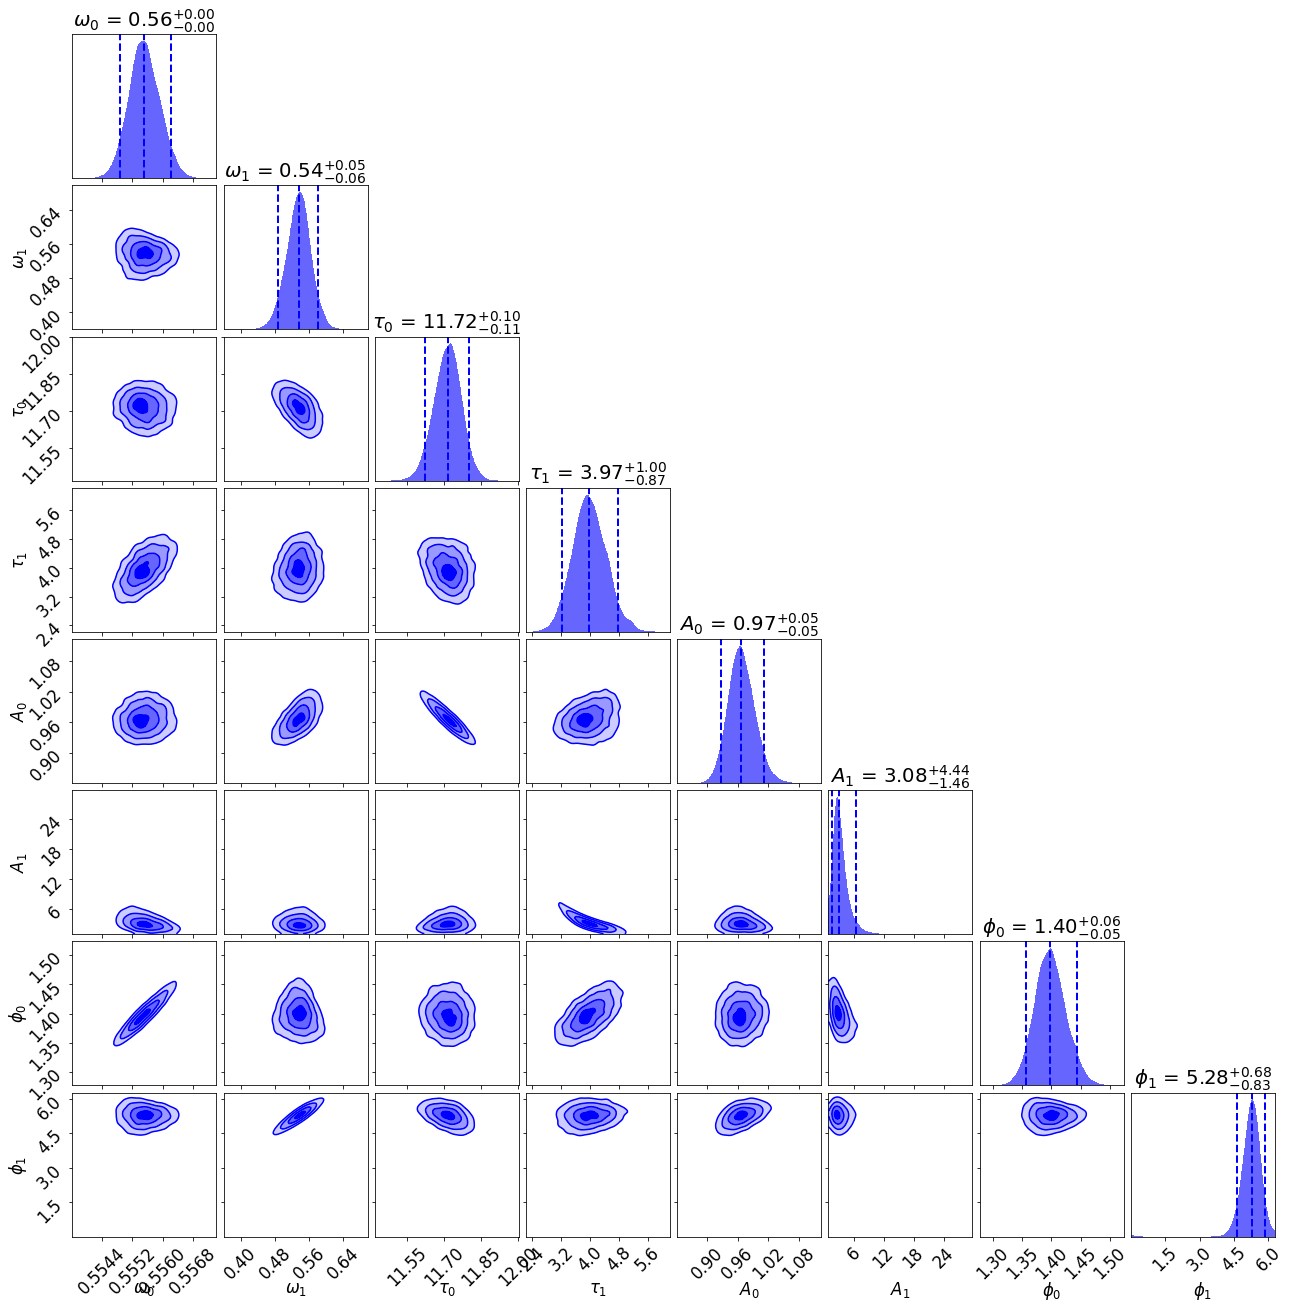

In [41]:
labels = [r'$\omega_0$', r'$\omega_1$',r'$\tau_0$',r'$\tau_1$',r'$A_0$', r'$A_1$',r'$\phi_0$',r'$\phi_1$']

fg, ax = dyplot.cornerplot(res, color='blue', 
                           show_titles=True,
                           labels=labels,
                           quantiles=(0.05,0.5,0.95),
)

In [110]:
fg.savefig(rootpath+'/git/rdstackingproject/plotsmc/Dynesty_withpointerrs_0001'+'nmax='+str(nmax)+'_tshift='+str(tshift)+'_'+str(npoints)+'pt_wandt_chainplot_lowres.png', format = 'png', bbox_inches = 'tight')

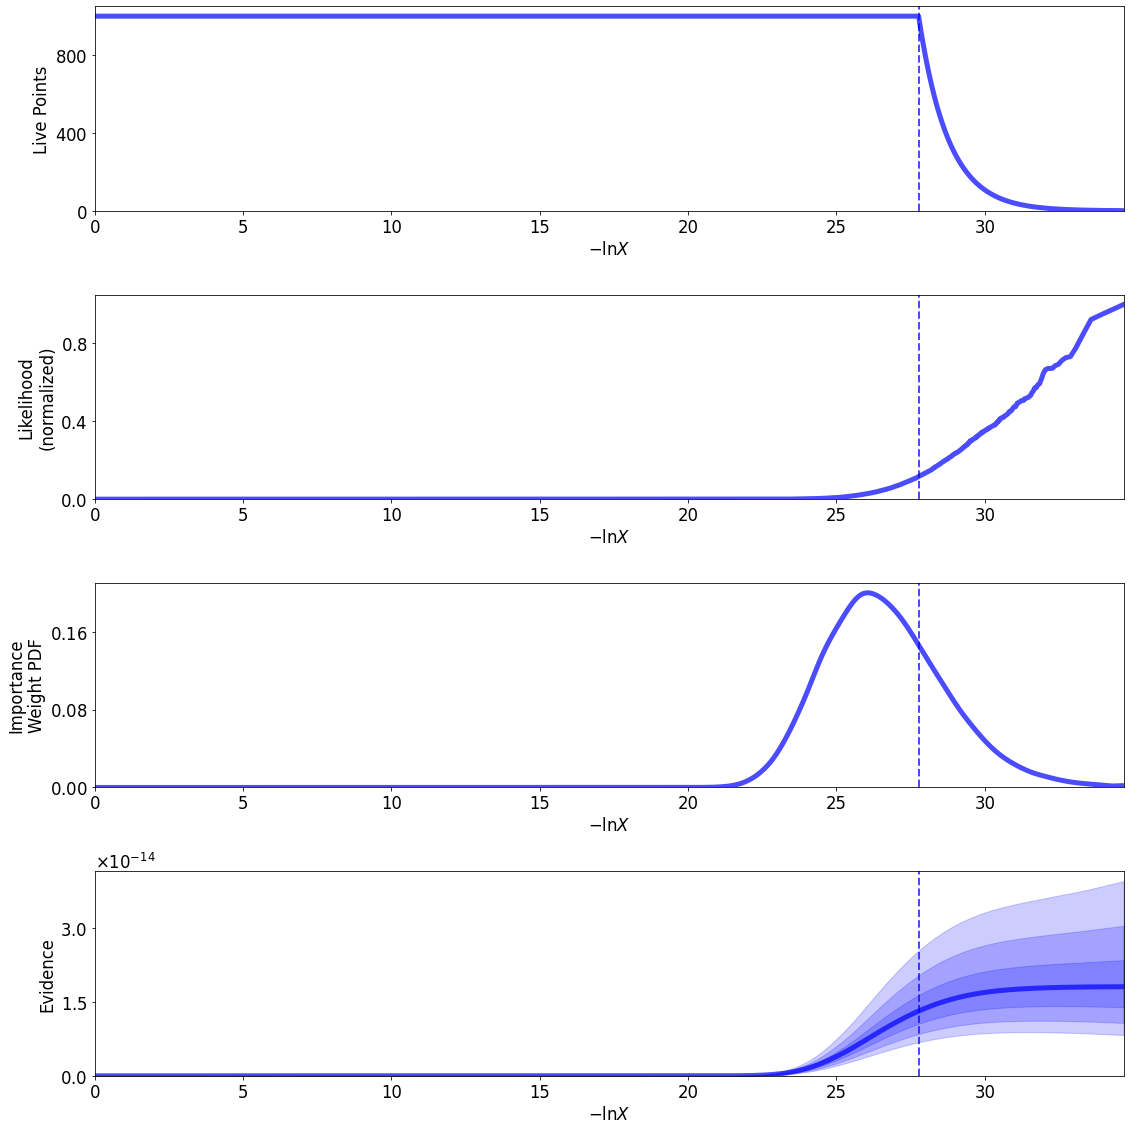

In [25]:
lnz_truth = ndim * -np.log(2 * 10.)  # analytic evidence solution
fig, axes = dyplot.runplot(res, lnz_truth=lnz_truth)
fig.tight_layout()

In [57]:
nmax=0
tshift=12
t_align=0
vary_fund = True

#sampler parameters
npoints = 1500
nwalkers = 400
npoints = 1000
ntemps=20
dim = nmax+1
ndim = 4*dim
burnin = 1200 

In [58]:
#Fitting
#RD model for nmax tones. Amplitudes are in (xn*Exp[i yn]) version. Used here.
def model_dv(theta):
    #x0, y0= theta
    #Your nmax might not align with the dim of theta. Better check it here.
    assert int(len(theta)/4) == dim, 'Please recheck your n and parameters'
    
    wvars = theta[ : (dim)]
    tvars = theta[(dim) : 2*(dim)]
    xvars = theta[2*(dim) : 3*(dim)]
    yvars = theta[3*(dim) : ]
    
    #if vary_fund == False:
    #    avars[0]=0
    #    bvars[0]=0
        
    ansatz = 0
    for i in range (0,dim):
        #bvars[1]=0
        #avars[1]=0
        ansatz += (xvars[i]*np.exp(1j*yvars[i]))*np.exp(-timesrd_final_tsh/tvars[i]) * (np.cos(wvars[i]*timesrd_final_tsh)-1j*np.sin(wvars[i]*timesrd_final_tsh))
    # -1j to agree with SXS convention
    return ansatz

# Logprior distribution. It defines the allowed range my variables can vary over. 
#It works for the (xn*Exp[iyn]) version. 

def prior_transform(cube):
    cube[0] =  0.5+ cube[0]*0.1
    cube[1] =  8 + cube[1]*8  
    cube[2] = 0 + cube[2]*3
    cube[3] = 0 + cube[3]*2*np.pi
    return cube


# LogLikelihood function. It is just a Gaussian loglikelihood based on computing the residuals^2
def log_likelihood(theta):
    modelev = model_dv(theta)
    result = -np.sum(((gwdatanew_re_tsh - modelev.real)**2+(gwdatanew_im_tsh - modelev.imag)**2)/(2*(error_tsh.real**2+error_tsh.imag**2)))
    if np.isnan(result):
        return -np.inf
    return result


# Logposterior distribution for the residuals case.
# The evidence is just a normalization factor
def log_probability(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta)

In [60]:
f2=dynesty.NestedSampler(log_likelihood, prior_transform, ndim, nlive=npoints)
f2.run_nested()

21047it [00:41, 501.87it/s, +1000 | bound: 35 | nc: 1 | ncall: 88724 | eff(%): 24.849 | loglstar:   -inf < -81.282 <    inf | logz: -102.305 +/-  0.213 | dlogz:  0.001 >  1.009]


In [62]:
res = f2.results
res.samples_u.shape
res.summary()

Summary
nlive: 1000
niter: 21047
ncall: 88724
eff(%): 24.849
logz: -102.305 +/-  0.213


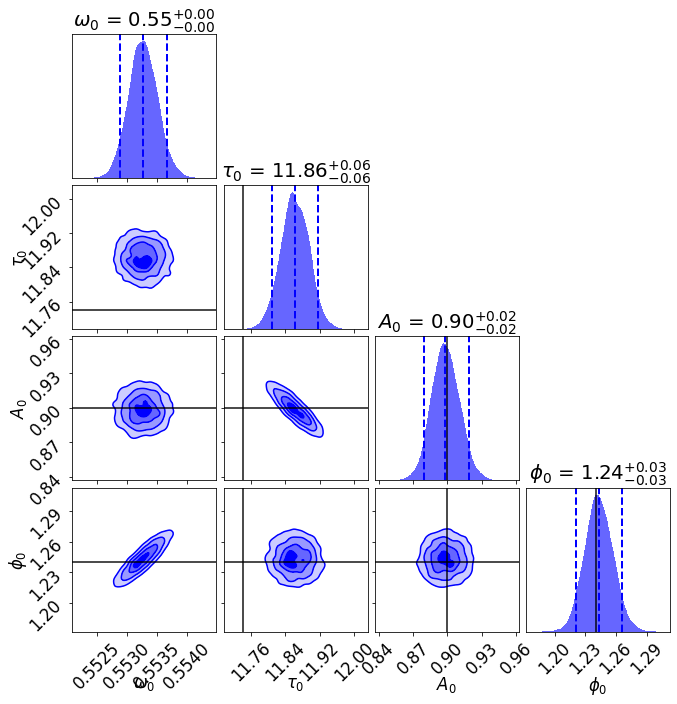

In [65]:
labels = [r'$\omega_0$',r'$\tau_0$',r'$A_0$',r'$\phi_0$']

fg, ax = dyplot.cornerplot(res, color='blue', 
                           show_titles=True,
                           labels=labels,
                           quantiles=(0.05,0.5,0.95),
                           truths=[w[0],tau[0],0.9,1.24],
                           truth_color='black'
                           )

In [158]:
#Fitting
#RD model for nmax tones. Amplitudes are in (xn*Exp[i yn]) version. Used here.
qval0=np.pi*w[0]
qval1=np.pi*w[1]
def model_dv(theta):
    #x0, y0= theta
    #Your nmax might not align with the dim of theta. Better check it here.
    assert int(len(theta)/4) == dim, 'Please recheck your n and parameters'
    
    wvars = theta[ : (dim)]
    qvars = theta[(dim) : 2*(dim)]
    xvars = theta[2*(dim) : 3*(dim)]
    yvars = theta[3*(dim) : ]
    
    
    ansatz = 0
    for i in range (0,dim):
        ansatz += (xvars[i]*np.exp(1j*yvars[i]))*np.exp(-timesrd_final_tsh*np.pi*wvars[i]/qvars[i])*(np.cos(wvars[i]*timesrd_final_tsh)-1j*np.sin(wvars[i]*timesrd_final_tsh))
    # -1j to agree with SXS convention
    return ansatz

def model_dv_tau(theta):
    #x0, y0= theta
    #Your nmax might not align with the dim of theta. Better check it here.
    assert int(len(theta)/4) == dim, 'Please recheck your n and parameters'
    
    wvars = theta[ : (dim)]
    tvars = theta[(dim) : 2*(dim)]
    xvars = theta[2*(dim) : 3*(dim)]
    yvars = theta[3*(dim) : ]
    
    #if vary_fund == False:
    #    avars[0]=0
    #    bvars[0]=0
        
    ansatz = 0
    for i in range (0,dim):
        #bvars[1]=0
        #avars[1]=0
        ansatz += (xvars[i]*np.exp(1j*yvars[i]))*np.exp(-timesrd_final_tsh/tvars[i]) * (np.cos(wvars[i]*timesrd_final_tsh)-1j*np.sin(wvars[i]*timesrd_final_tsh))
    # -1j to agree with SXS convention
    return ansatz

# Logprior distribution. It defines the allowed range my variables can vary over. 
#It works for the (xn*Exp[iyn]) version. 

def prior_transform(cube):
    cube[0] =  0.5+ cube[0]*0.1
    cube[1] =  0.35 + cube[1]*0.35
    cube[2] =  (8 + cube[2]*8)*qval0
    cube[3] =  (0 + cube[3]*7)*qval1
    cube[4] = 0 + cube[4]*3
    cube[5] = 0 + cube[5]*30
    cube[6] = 0 + cube[6]*2*np.pi
    cube[7] = 0 + cube[7]*2*np.pi
    return cube


# LogLikelihood function. It is just a Gaussian loglikelihood based on computing the residuals^2
def log_likelihood(theta):
    modelev = model_dv(theta)
    result = -np.sum(((gwdatanew_re_tsh - modelev.real)**2+(gwdatanew_im_tsh - modelev.imag)**2)/(2*(error_tsh.real**2+error_tsh.imag**2)))
    if np.isnan(result):
        return -np.inf
    return result


# Logposterior distribution for the residuals case.
# The evidence is just a normalization factor
def log_probability(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta)

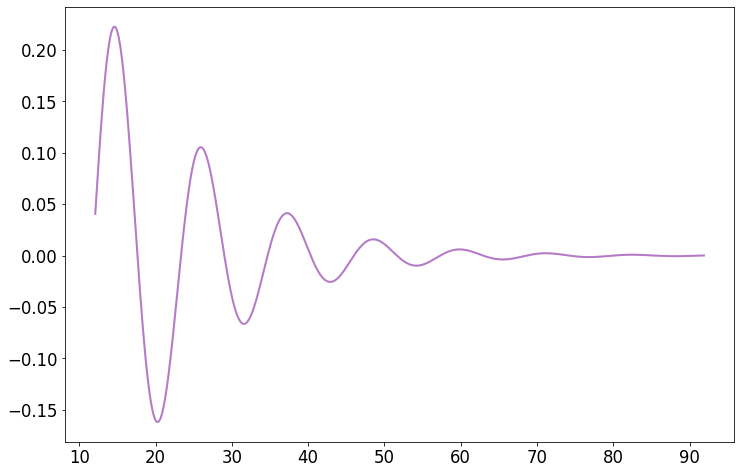

In [159]:
plt.figure(figsize = (12, 8))
plt.plot(timesrd_final_tsh, model_dv([w[0],w[1],qval0*tau[0],qval1*tau[1],1,3,2,-1]).real, "r", alpha=0.3, lw=2, label='q')
plt.plot(timesrd_final_tsh, model_dv_tau([w[0],w[1],tau[0],tau[1],1,3,2,-1]).real, "b", alpha=0.3, lw=2, label='tau')

In [ ]:
f2=dynesty.NestedSampler(log_likelihood, prior_transform, ndim, nlive=npoints)
f2.run_nested()

26648it [52:33,  1.35s/it, bound: 1443 | nc: 1455 | ncall: 2546139 | eff(%):  1.047 | loglstar:   -inf < -8.253 <    inf | logz: -34.462 +/-  0.222 | dlogz:  3.727 >  1.009]    

In [ ]:
res = f2.results
res.samples_u.shape
res.summary()

In [ ]:
labels = [r'$\omega_0$', r'$\omega_1$',r'$q_0$',r'$q_1$',r'$A_0$', r'$A_1$',r'$\phi_0$',r'$\phi_1$']

fg, ax = dyplot.cornerplot(res, color='blue', 
                           show_titles=True,
                           labels=labels,
                           quantiles=(0.05,0.5,0.95),
)